# Clustering with pytbc
In this tutorial we show how to use **pytbc** to cluster different types of data with the tree-based clustering algorithm (TBC).

In [1]:
%matplotlib inline
# imports
import numpy as np
from pytbc.tree_based import TreeBased
import matplotlib.pyplot as plt
from itertools import cycle, islice

### 2D Point distribution
We start with the example of a 2D uniform point distribution. We sample the *x* and *y* coordinates of points uniformly from the interval [0-100]. <br>

In [2]:
# generating the data:
nsnaps = 2000
nfeats = 2
cludata = 100 * np.random.random_sample((nfeats, nsnaps)) + 0.

Diffently from K-means clustering algorithm, TBC does not allow to set the number of cluster K in advance. This is inferred from the data according to the clustering resolution which is required. The algorithm uses a divisive hierarchical approach. Starting from the root level (coarsest resolution set by *cmaxrad*), at each level of the tree points are clustered with finer and finer resolution, down to *cradius* at the leaf level. The height of the tree is set with *nlevels* and resolution thresholds scale linearly from *cmaxrad* to *cradius*. <br>
The other important parameter to choose is the metrics used to evaluate the distance among points. Possible choices are the Euclidean distance (cdis_crit = 7) or two similar dihedral distances (cdis_crit = 1 takes into account the angle periodicity, cdis_crit = 3 decompose the angle into its sin and cos components), which are very useful in the analysis of biomolecules.
For the 2D point distribution we will use the Euclidean distance. <br><br>
The TreeBased object is first constructed, provinding the relevant parameters and then fitted on the data (similar to the sklearn clustering API).

In [3]:
# initialization:
tbc_2d_points = TreeBased(cmaxrad=40.0, cradius=20.0, nlevels=8,
                          cdis_crit=7, c_multires=1)
# fit:
y_pred = tbc_2d_points.fit(cludata)

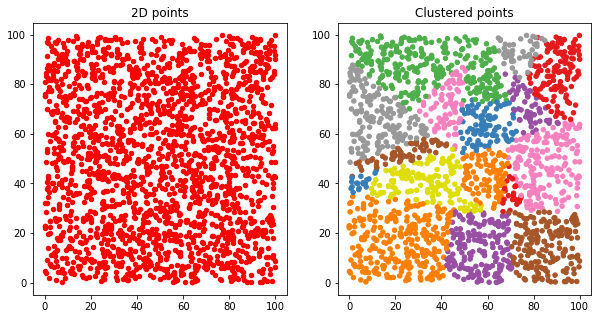

In [4]:
# plots:
plt.rcParams['figure.figsize'] = [10, 5]
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter(cludata[0,:], cludata[1,:], s=20, color='r')
ax1.set_title('2D points')

clus = y_pred[:,0]
clus = clus.astype(int) # cast to int
# coloring by cluster (repeating colors):
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                     '#f781bf', '#a65628', '#984ea3',
                                     '#999999', '#e41a1c', '#dede00']),
                                     int(max(clus) + 1))))
# add black color for outliers (if any)
colors = np.append(colors, ["#000000"])

ax2.scatter(cludata[0,:], cludata[1,:], s=20, color=colors[clus])
ax2.set_title('Clustered points')
plt.show()

### 2D Gaussian blobs
Here we show the clustering on isotropic Gaussian blobs. An advantage of the TBC is that it does not require to specify in advance the number of clusters, but the finest resolution at which we want to cluster the data.

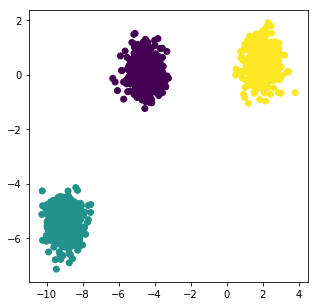

In [5]:
from sklearn.datasets import make_blobs
# make blobs:
n_samples = 1500
random_state = 170
X, y = make_blobs(n_samples=n_samples, random_state=random_state, cluster_std = 0.5)

tbc_blobs = TreeBased(cdis_crit=7, nlevels=4, cradius=2.0, cmaxrad=5.0)
y_pred = tbc_blobs.fit(np.transpose(X))

plt.rcParams['figure.figsize'] = [5, 5]
plt.scatter(X[:, 0], X[:, 1], c = y_pred[:,0].astype(int))
plt.show()

### 1D Polar blobs
In many applications it is useful to represent a system by means of angles (for example dihedral angles describing the conformation of a biomolecule). Distances between angles require particular attention due to their periodic nature. The TBC algorithm implements two angular distances (`cdis_crit = 1` or `cdis_crit = 3`) to deal with angular features; `cdis_crit = 1` treats the periodicity directly whereas `cdis_crit = 2` uses sin and cos components (this means that they will give similar results, but will need different parameters for `cradius` and `cmaxrad`!).

In this example we generate two blobs: the first centered around 0°, the second one centered around 180° (or -180°).

We see that using the Euclidean distance directly (without calculating the sin/cos components) splits the values around -180° and +180° into two clusters because it does not take periodicity into accout; on the other hand the
two dihedral metrics gives the intuitively expected result.

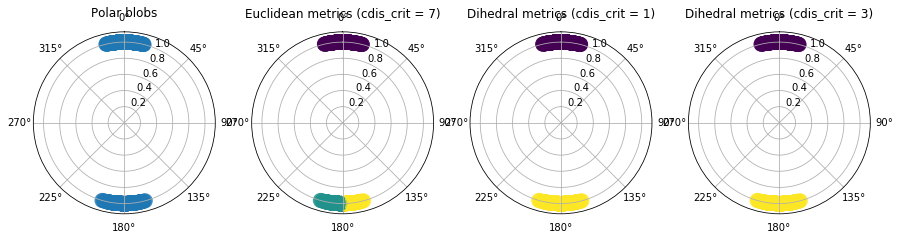

In [6]:
n_samples = 700
# building two blobs (one centered around 0 degrees, the other centered around 180 degrees)
blob_0 = np.random.normal(loc=0.0, scale=5.0, size=n_samples)
blob_180 = np.concatenate((np.random.normal(loc=180.0, scale=5.0, size = int(n_samples/2)), 
                          np.random.normal(loc=-180.0, scale=5.0, size = int(n_samples/2))))
X = np.concatenate((blob_0, blob_180)).reshape((1, n_samples*2))
X = (((np.round(X)+180)%360)-180) # convert to interval [-180, +180]

# cdis_crit = 7
tbc_euclid = TreeBased(cdis_crit=7, nlevels=4, cradius=45, cmaxrad=90)
y_pred_euclid = tbc_euclid.fit(X)
# cdis_crit = 1
tbc_angle = TreeBased(cdis_crit=1, nlevels=4, cradius=45, cmaxrad=90)
y_pred_angle = tbc_angle.fit(X)
# cdis_crit = 3
tbc_angle2 = TreeBased(cdis_crit=3, nlevels=4, cradius=0.5, cmaxrad=10)
y_pred_angle2 = tbc_angle2.fit(X) 

# polar plots:
r = np.concatenate((np.repeat(1.0, n_samples), np.repeat(1.0, (n_samples/2)), np.repeat(1.0, (n_samples/2)))) 
theta = 2 * np.pi * X[0,:]/360.0
area = 200 * r**2

plt.rcParams['figure.figsize'] = [15, 5]
fig = plt.figure()
ax1 = fig.add_subplot(141, projection='polar')
c = ax1.scatter(theta, r, s=area, alpha=0.75)
ax1.set_theta_zero_location('N', offset=0)
ax1.set_theta_direction(-1)
ax1.set_title('Polar blobs')

ax2 = fig.add_subplot(142, projection='polar')
c = ax2.scatter(theta, r, s=area, alpha=0.75, c=y_pred_euclid[:,0].astype(int))
ax2.set_theta_zero_location('N', offset=0)
ax2.set_theta_direction(-1)
ax2.set_title('Euclidean metrics (cdis_crit = 7)')

ax3 = fig.add_subplot(143, projection='polar')
c = ax3.scatter(theta, r, s=area, alpha=0.75, c=y_pred_angle[:,0].astype(int))
ax3.set_theta_zero_location('N', offset=0)
ax3.set_theta_direction(-1)
ax3.set_title('Dihedral metrics (cdis_crit = 1)')

ax4 = fig.add_subplot(144, projection='polar')
c = ax4.scatter(theta, r, s=area, alpha=0.75, c=y_pred_angle2[:,0].astype(int))
ax4.set_theta_zero_location('N', offset=0)
ax4.set_theta_direction(-1)
ax4.set_title('Dihedral metrics (cdis_crit = 3)')
plt.show()

### Alanine dipeptide trajectory
The TBC algorithm is particularly suitable for clustering molecular conformations from Monte Carlo (MC) or Molecular Dynamics (MD) trajectories. We show here how to cluster a MC trajectory of the alanine dipeptide using as features its PHI and PSI angle and a dihedral distance (cdis_crit = 1). <br>
We make use of PyEMMA to load the trajectory and extract the features.

In [7]:
import pyemma

pdb = '../../../extdata/ala2_START.pdb'
files = ['../../../extdata/ala2_traj.xtc']
feat = pyemma.coordinates.featurizer(pdb)
feat.add_backbone_torsions(periodic=False)
data = pyemma.coordinates.load(files, features=feat)
if len(files) > 1:
    data_concat = np.concatenate(data)
else:
    data_concat = data

/home/cassiano/anaconda2/envs/py37/lib/python3.7/site-packages/pyemma/util/log.py:64: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  D = yaml.load(f2)
/home/cassiano/anaconda2/envs/py37/lib/python3.7/site-packages/pyemma/__init__.py:92: UserWarning: You are not using the latest release of PyEMMA. Latest is 2.5.7, you have 2.5.5.
  .format(latest=latest, current=current), category=UserWarning)


TBC with cdis_crit = 1 expects data in the interval [-180.0, +180.0] degrees. As the data extracted from the featurizer are in radians we convert them to degrees. We also check the shape of the data, which is *number of snapshots* times *number of features* and should be transposed to be fitted with TBC.

In [8]:
print(data_concat.shape)
print(np.min(data_concat, axis=0), np.max(data_concat, axis=0)) # shows that the data are in radians
data_deg = data_concat * 180.0/np.pi # convert to degrees
print(np.min(data_deg, axis=0), np.max(data_deg, axis=0)) # check new ranges

(49000, 2)
[-3.1415863 -3.1415155] [3.1415439 3.1415315]
[-179.99963 -179.99557] [179.99721 179.99649]


In [9]:
# Now clustering using cdis_crit = 1:
tbc_ala = TreeBased(cmaxrad=120.0, cradius=10.0, nlevels=8,
                    cdis_crit=1)
y_pred = tbc_ala.fit(np.transpose(data_deg)) # note that we transpose

We plot the points on the Ramachandran plot and color according to the cluster:

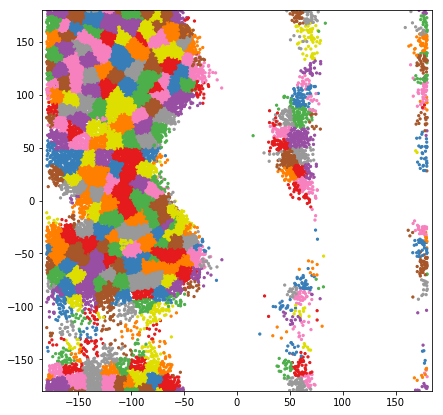

In [10]:
# Ramachandran plot:
plt.rcParams['figure.figsize'] = [7, 7]
clus = np.squeeze(y_pred.astype(int))
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a', 
                                     '#f781bf', '#a65628', '#984ea3',
                                     '#999999', '#e41a1c', '#dede00']),
                                     int(max(clus) + 1))))
# add black color for outliers (if any)
colors = np.append(colors, ["#000000"])
plt.scatter(data_deg[:,0], data_deg[:,1], s=5, color=colors[clus])
plt.axis('equal')
plt.ylim(-180.0, 180.0)
plt.xlim(-180.0, 180.0)
plt.show()

### Building a Markov State Model from using **pytbc** for discretizing the trajectory
Clustering algorithms can be used to discretize an MD trajectory in order to build a Markov State Model (MSM). The TBC algorithm is particularly suitable for this purpose. We show here a comparison between TBC (with the dihedral metric) and kmeans++ (with Euclidean metric) for discretizing an MD trajectory of alanine dipeptide and further building an MSM. 
Note that we make use of mdshare to retrieve an example MD trajectory and PyEMMA to build the MSM directly in Python.
We use on purpose a low number of centroids to highlight the differences between kmeans++ and TBC.

In [11]:
# get data
import mdshare
pdb = mdshare.fetch('alanine-dipeptide-nowater.pdb', working_directory='../../../extdata/')
files = mdshare.fetch('alanine-dipeptide-*-250ns-nowater.xtc', working_directory='../../../extdata/')

/home/cassiano/anaconda2/envs/py37/lib/python3.7/site-packages/mdshare/repository.py:53: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = load(fh)


In [12]:
# featurizing
feat = pyemma.coordinates.featurizer(pdb)
feat.add_backbone_torsions(periodic=False)
data = pyemma.coordinates.load(files, features=feat)
if len(files) > 1:
    data_cat = np.concatenate(data)
else:
    data_cat = data 
    
# cluster with kmeans++
cluster = pyemma.coordinates.cluster_kmeans(data_cat, k=20, max_iter=200, stride=10)
# building MSM and calculating the implied timescales:
its_kmeans = pyemma.msm.its(cluster.dtrajs, lags=[1, 2, 5, 10, 20, 50], nits=4, errors='bayes')

In [13]:
# preprocess for TBC:
data_deg = np.transpose(data_cat * 180.0/np.pi) # convert to degrees
# cluster with TBC:
tbc_ala = TreeBased(cmaxrad=120.0, cradius=60.0, nlevels=8,
                       cdis_crit=1)
y_pred = tbc_ala.fit(data_deg)
# building MSM and calculating the implied timescales:
its_tbc = pyemma.msm.its(np.squeeze(y_pred.astype(int)), lags=[1, 2, 5, 10, 20, 50], nits=4, errors='bayes')

We can see that kmeans centroids are more evenly distributed than TBC centroids (setting the thresholds in order to have a comparable number of clusters). The TBC clusters better resolve the slow modes of the dynamics as can be seen from the slowest implied timescales from the MSM. In particular, with TBC, all the timescales converge faster to the plateau as a function of lag time, and we are also able to resolve the third slowest timescale (green line), which cannot be resolved with the kmeans clusters (it is faster than the MSM lag time, as it lies in the shaded area).

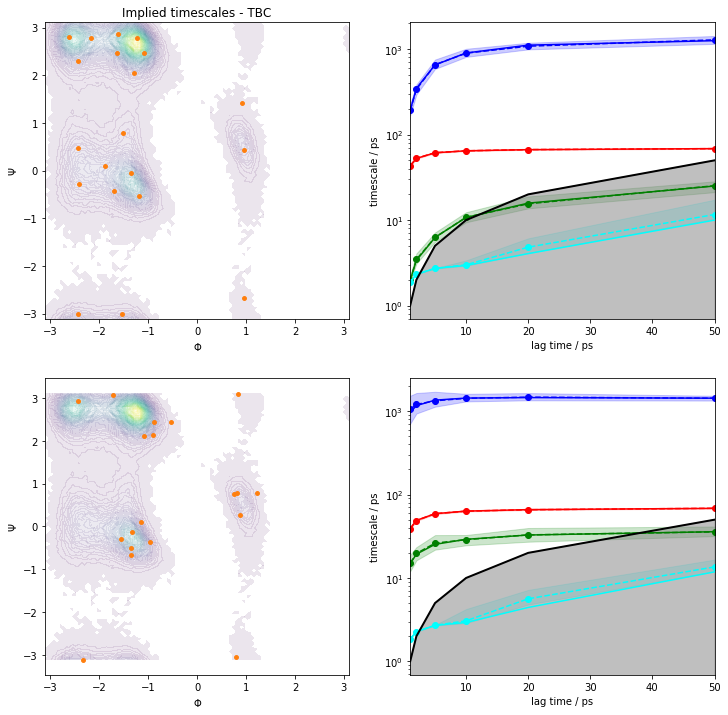

In [14]:
# plots of implied timescales and centroid positions:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
# density and centroids - kmeans
pyemma.plots.plot_density(*data_cat.T, ax=axes[0][0], cbar=False, alpha=0.1)
axes[0][0].scatter(*cluster.clustercenters.T, s=15, c='C1')
axes[0][0].set_xlabel('$\Phi$')
axes[0][0].set_ylabel('$\Psi$')
axes[0][0].set_title('Centroids - KMeans')
# implied timescales - kmeans
pyemma.plots.plot_implied_timescales(its_kmeans, ax=axes[0][1], units='ps')
axes[0][0].set_title('Implied timescales - KMeans')
# density and centroids - tbc
tbc_c_xy = data_cat[tbc_ala.centroids,:]
pyemma.plots.plot_density(*data_cat.T, ax=axes[1][0], cbar=False, alpha=0.1)
axes[1][0].scatter(*tbc_c_xy.T, s=15, c='C1')
axes[1][0].set_xlabel('$\Phi$')
axes[1][0].set_ylabel('$\Psi$')
axes[0][0].set_title('Centroids - TBC')
# implied timescales - tbc
pyemma.plots.plot_implied_timescales(its_tbc, ax=axes[1][1], units='ps')
axes[0][0].set_title('Implied timescales - TBC')
plt.show()